In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples = load_test_data() / 255.0

In [3]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [4]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 20
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):

        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
  
        
        self.fake_samples_op = self._generator(self.noise) 
            
        self.dis_loss_op = self._loss(self.fake_label,self._discriminator(self.fake_samples_op))+self._loss(self.real_label,self._discriminator(self.real_input))
            
        self.gen_loss_op = self._loss(self.fake_label,self._discriminator(self.fake_samples_op))
        
        

        
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis'))
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen'))
 
        
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
      
        
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op,self.recon_sample)
        
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op ,var_list = [self.actmax_code])


    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
       
                
                dis_feed_dict = {self.noise:noise,self.real_input:batch_samples,
                                 self.real_label:ones,self.fake_label:zeros,self.is_train:True}
                
          

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                
                gen_feed_dict = {self.noise:noise,self.fake_label:ones,self.is_train:True}


                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    def reconstruct_one_sample(self, sample):
        

        
        actmax_init_val = tf.zeros(self.actmax_code.shape)

        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        

            
            recon_feed_dict = {self.actmax_label:np.ones([1, 1]),self.recon_sample:sample,self.is_train:False}

            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        

        
        gen_vis_feed_dict = {self.noise:code,self.is_train:False}

        
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
                
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Start training ...
Iteration 50/31240: dis loss = 0.4689, gen loss = 2.1448
Iteration 100/31240: dis loss = 0.0753, gen loss = 4.0165
Iteration 150/31240: dis loss = 0.1909, gen loss = 5.2802
Iteration 200/31240: dis loss = 0.1895, gen loss = 2.8299
Iteration 250/31240: dis loss = 0.0450, gen loss = 4.2758
Iteration 300/31240: dis loss = 0.3089, gen loss = 1.2949
Iteration 350/31240: dis loss = 0.6677, gen loss = 1.3216


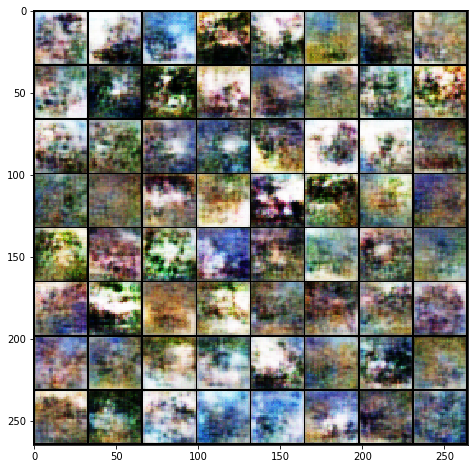

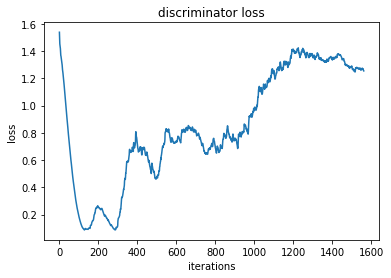

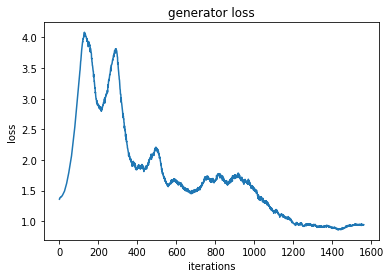

Iteration 1600/31240: dis loss = 1.1434, gen loss = 0.9131
Iteration 1650/31240: dis loss = 1.1172, gen loss = 0.8864
Iteration 1700/31240: dis loss = 1.0613, gen loss = 1.3389
Iteration 1750/31240: dis loss = 1.0489, gen loss = 1.1411
Iteration 1800/31240: dis loss = 1.3016, gen loss = 0.7403
Iteration 1850/31240: dis loss = 1.1727, gen loss = 1.1770
Iteration 1900/31240: dis loss = 0.9936, gen loss = 1.1718
Iteration 1950/31240: dis loss = 1.2328, gen loss = 0.9873
Iteration 2000/31240: dis loss = 1.1749, gen loss = 1.0961
Iteration 2050/31240: dis loss = 1.1301, gen loss = 1.2569
Iteration 2100/31240: dis loss = 1.2361, gen loss = 0.5405
Iteration 2150/31240: dis loss = 1.3428, gen loss = 0.6637
Iteration 2200/31240: dis loss = 1.2113, gen loss = 0.7704
Iteration 2250/31240: dis loss = 1.1982, gen loss = 0.7484
Iteration 2300/31240: dis loss = 1.3582, gen loss = 0.6888
Iteration 2350/31240: dis loss = 1.0592, gen loss = 1.1839
Iteration 2400/31240: dis loss = 1.2646, gen loss = 0.74

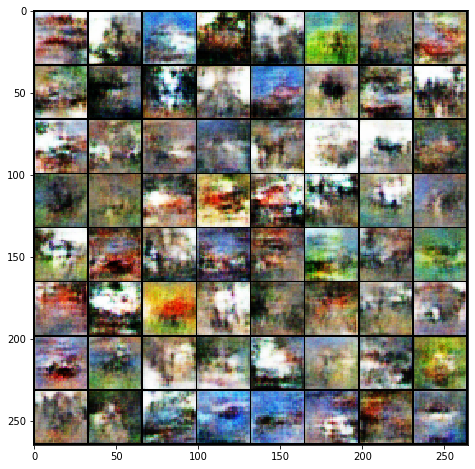

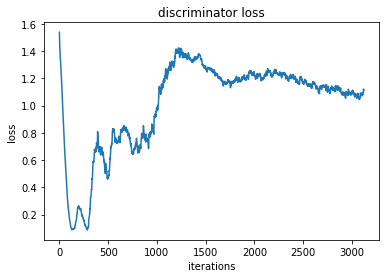

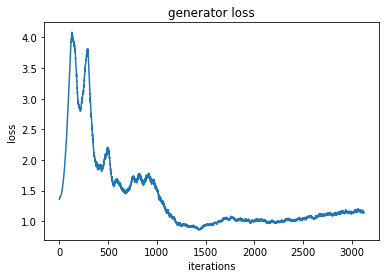

Iteration 3150/31240: dis loss = 0.9587, gen loss = 1.4402
Iteration 3200/31240: dis loss = 1.0329, gen loss = 1.5239
Iteration 3250/31240: dis loss = 1.0637, gen loss = 1.0275
Iteration 3300/31240: dis loss = 0.9944, gen loss = 0.8473
Iteration 3350/31240: dis loss = 1.1046, gen loss = 0.9244
Iteration 3400/31240: dis loss = 1.1279, gen loss = 1.5876
Iteration 3450/31240: dis loss = 1.0402, gen loss = 1.4960
Iteration 3500/31240: dis loss = 1.0328, gen loss = 1.7752
Iteration 3550/31240: dis loss = 0.9341, gen loss = 1.5068
Iteration 3600/31240: dis loss = 0.9896, gen loss = 1.5165
Iteration 3650/31240: dis loss = 0.9228, gen loss = 0.9507
Iteration 3700/31240: dis loss = 0.9442, gen loss = 1.2003
Iteration 3750/31240: dis loss = 1.2873, gen loss = 0.6647
Iteration 3800/31240: dis loss = 1.1130, gen loss = 0.8336
Iteration 3850/31240: dis loss = 0.8223, gen loss = 1.2208
Iteration 3900/31240: dis loss = 1.2946, gen loss = 0.5445
Iteration 3950/31240: dis loss = 0.8537, gen loss = 1.04

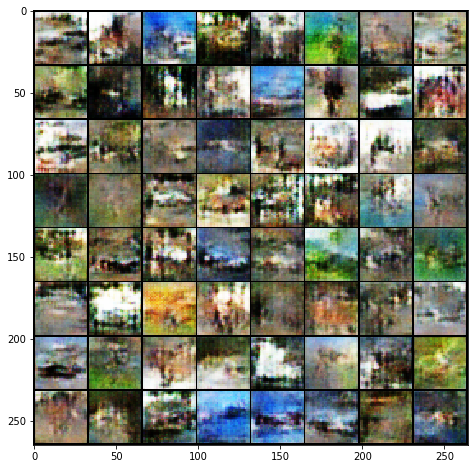

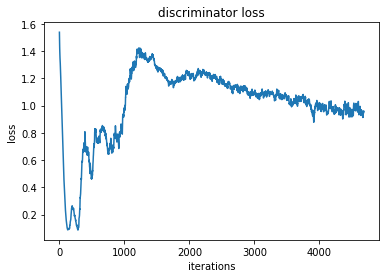

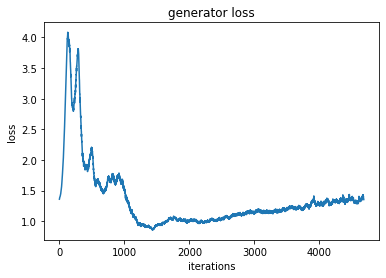

Iteration 4700/31240: dis loss = 0.9619, gen loss = 0.8035
Iteration 4750/31240: dis loss = 0.9093, gen loss = 1.9324
Iteration 4800/31240: dis loss = 0.9109, gen loss = 1.0937
Iteration 4850/31240: dis loss = 0.9342, gen loss = 1.2838
Iteration 4900/31240: dis loss = 0.8800, gen loss = 0.7103
Iteration 4950/31240: dis loss = 1.0959, gen loss = 0.8050
Iteration 5000/31240: dis loss = 0.6981, gen loss = 1.2018
Iteration 5050/31240: dis loss = 0.4803, gen loss = 1.9077
Iteration 5100/31240: dis loss = 1.4810, gen loss = 1.6504
Iteration 5150/31240: dis loss = 1.3293, gen loss = 0.5580
Iteration 5200/31240: dis loss = 0.9667, gen loss = 1.6444
Iteration 5250/31240: dis loss = 0.9285, gen loss = 1.1705
Iteration 5300/31240: dis loss = 1.3903, gen loss = 2.0938
Iteration 5350/31240: dis loss = 0.7903, gen loss = 1.0204
Iteration 5400/31240: dis loss = 1.2799, gen loss = 0.3405
Iteration 5450/31240: dis loss = 1.8738, gen loss = 1.6539
Iteration 5500/31240: dis loss = 0.8061, gen loss = 1.87

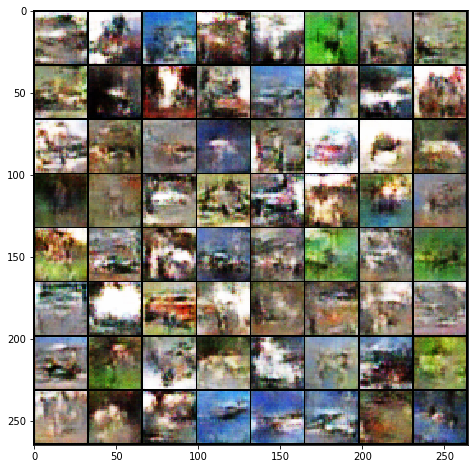

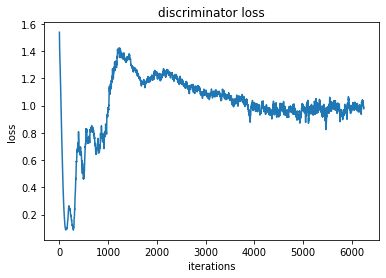

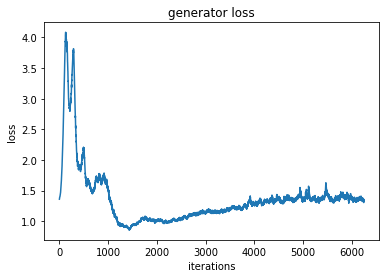

Iteration 6250/31240: dis loss = 1.2671, gen loss = 0.7020
Iteration 6300/31240: dis loss = 0.9885, gen loss = 0.9979
Iteration 6350/31240: dis loss = 0.9288, gen loss = 0.7838
Iteration 6400/31240: dis loss = 1.1347, gen loss = 1.8410
Iteration 6450/31240: dis loss = 0.5872, gen loss = 1.6360
Iteration 6500/31240: dis loss = 0.8476, gen loss = 1.6566
Iteration 6550/31240: dis loss = 0.8569, gen loss = 1.7297
Iteration 6600/31240: dis loss = 1.1710, gen loss = 1.7939
Iteration 6650/31240: dis loss = 1.1407, gen loss = 0.7892
Iteration 6700/31240: dis loss = 0.8171, gen loss = 2.2883
Iteration 6750/31240: dis loss = 0.9814, gen loss = 0.8281
Iteration 6800/31240: dis loss = 1.0813, gen loss = 1.2314
Iteration 6850/31240: dis loss = 0.9647, gen loss = 0.7660
Iteration 6900/31240: dis loss = 0.9733, gen loss = 1.9126
Iteration 6950/31240: dis loss = 0.9861, gen loss = 1.9304
Iteration 7000/31240: dis loss = 0.9329, gen loss = 1.0341
Iteration 7050/31240: dis loss = 0.9405, gen loss = 1.80

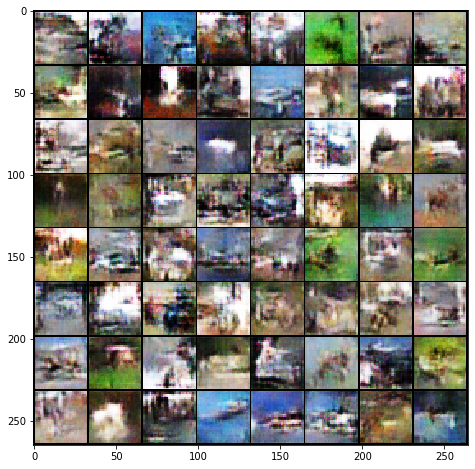

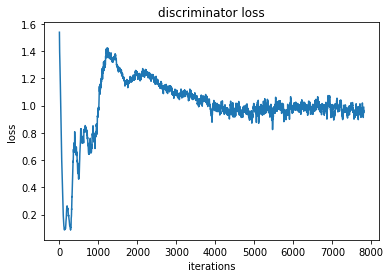

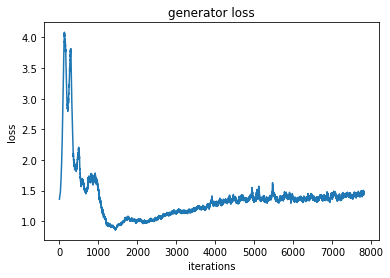

Iteration 7850/31240: dis loss = 1.1437, gen loss = 0.6833
Iteration 7900/31240: dis loss = 0.6947, gen loss = 2.1115
Iteration 7950/31240: dis loss = 0.9003, gen loss = 1.5164
Iteration 8000/31240: dis loss = 0.8605, gen loss = 1.8276
Iteration 8050/31240: dis loss = 1.1681, gen loss = 2.2936
Iteration 8100/31240: dis loss = 0.9245, gen loss = 0.7114
Iteration 8150/31240: dis loss = 0.9938, gen loss = 1.8376
Iteration 8200/31240: dis loss = 1.3125, gen loss = 2.1730
Iteration 8250/31240: dis loss = 0.8250, gen loss = 1.2888
Iteration 8300/31240: dis loss = 0.7369, gen loss = 1.0561
Iteration 8350/31240: dis loss = 0.9512, gen loss = 1.0125
Iteration 8400/31240: dis loss = 0.7817, gen loss = 1.1981
Iteration 8450/31240: dis loss = 1.1729, gen loss = 0.7318
Iteration 8500/31240: dis loss = 0.9640, gen loss = 1.2953
Iteration 8550/31240: dis loss = 1.2641, gen loss = 0.4258
Iteration 8600/31240: dis loss = 0.8085, gen loss = 1.0772
Iteration 8650/31240: dis loss = 0.7992, gen loss = 2.14

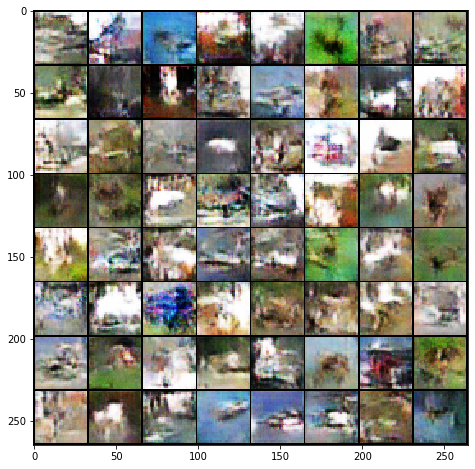

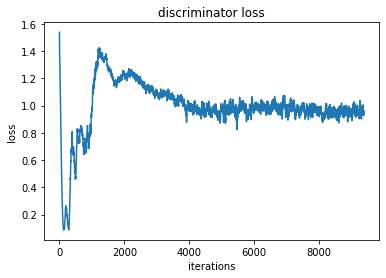

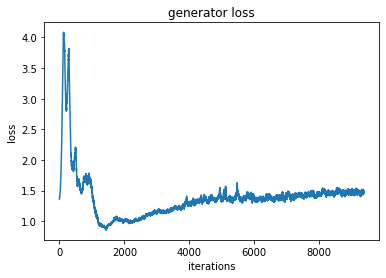

Iteration 9400/31240: dis loss = 1.1908, gen loss = 0.6870
Iteration 9450/31240: dis loss = 1.0798, gen loss = 2.1936
Iteration 9500/31240: dis loss = 1.2315, gen loss = 1.7033
Iteration 9550/31240: dis loss = 0.7739, gen loss = 1.9168
Iteration 9600/31240: dis loss = 0.7613, gen loss = 1.8146
Iteration 9650/31240: dis loss = 1.5118, gen loss = 0.6816
Iteration 9700/31240: dis loss = 0.7000, gen loss = 1.5695
Iteration 9750/31240: dis loss = 0.4665, gen loss = 1.8672
Iteration 9800/31240: dis loss = 1.3428, gen loss = 2.1561
Iteration 9850/31240: dis loss = 0.8932, gen loss = 0.6973
Iteration 9900/31240: dis loss = 0.7249, gen loss = 0.9506
Iteration 9950/31240: dis loss = 1.1484, gen loss = 2.3682
Iteration 10000/31240: dis loss = 1.2692, gen loss = 0.8603
Iteration 10050/31240: dis loss = 0.9433, gen loss = 1.6853
Iteration 10100/31240: dis loss = 1.1137, gen loss = 0.8703
Iteration 10150/31240: dis loss = 0.8733, gen loss = 1.0514
Iteration 10200/31240: dis loss = 1.1759, gen loss =

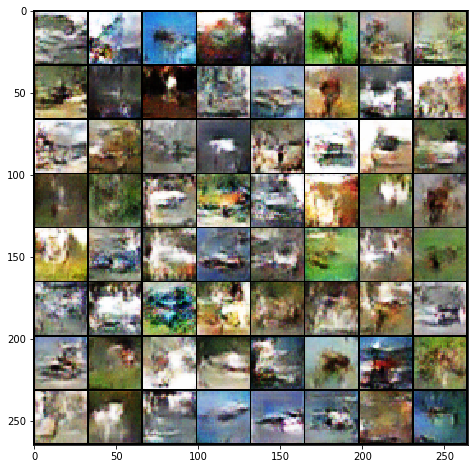

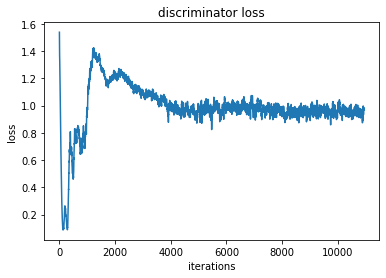

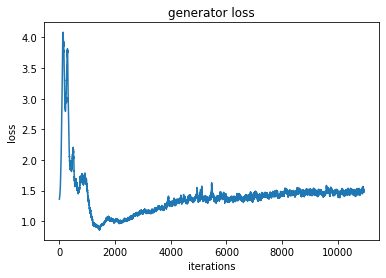

Iteration 10950/31240: dis loss = 0.9680, gen loss = 0.9758
Iteration 11000/31240: dis loss = 0.9464, gen loss = 2.3172
Iteration 11050/31240: dis loss = 1.0998, gen loss = 2.0677
Iteration 11100/31240: dis loss = 0.8020, gen loss = 0.9583
Iteration 11150/31240: dis loss = 1.0107, gen loss = 1.7378
Iteration 11200/31240: dis loss = 0.7874, gen loss = 1.2131
Iteration 11250/31240: dis loss = 0.6186, gen loss = 2.1458
Iteration 11300/31240: dis loss = 0.6982, gen loss = 1.4895
Iteration 11350/31240: dis loss = 0.7735, gen loss = 1.5998
Iteration 11400/31240: dis loss = 0.6962, gen loss = 1.7865
Iteration 11450/31240: dis loss = 1.9569, gen loss = 0.3390
Iteration 11500/31240: dis loss = 0.8230, gen loss = 2.0892
Iteration 11550/31240: dis loss = 0.9631, gen loss = 2.3954
Iteration 11600/31240: dis loss = 0.9155, gen loss = 2.4351
Iteration 11650/31240: dis loss = 0.7579, gen loss = 0.8190
Iteration 11700/31240: dis loss = 0.9626, gen loss = 0.7438
Iteration 11750/31240: dis loss = 1.1034

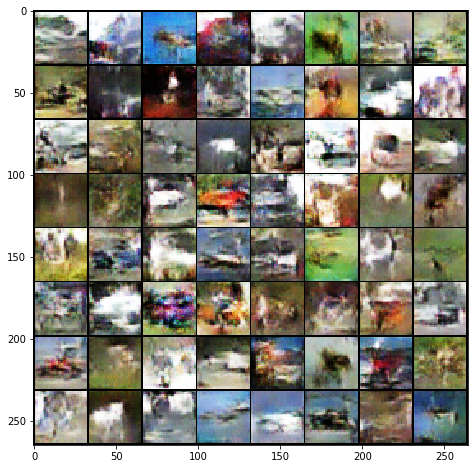

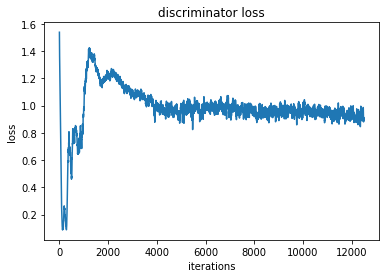

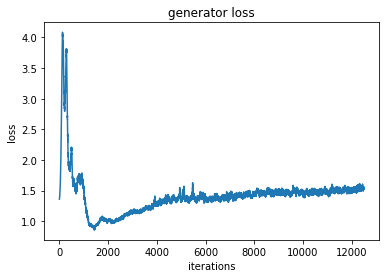

Iteration 12500/31240: dis loss = 0.8844, gen loss = 0.8962
Iteration 12550/31240: dis loss = 0.6337, gen loss = 1.5350
Iteration 12600/31240: dis loss = 1.0169, gen loss = 0.8663
Iteration 12650/31240: dis loss = 0.9774, gen loss = 2.0280
Iteration 12700/31240: dis loss = 0.8414, gen loss = 1.9730
Iteration 12750/31240: dis loss = 0.6835, gen loss = 1.2591
Iteration 12800/31240: dis loss = 1.0842, gen loss = 0.8836
Iteration 12850/31240: dis loss = 1.0988, gen loss = 0.7469
Iteration 12900/31240: dis loss = 0.6427, gen loss = 1.9738
Iteration 12950/31240: dis loss = 0.8322, gen loss = 2.1674
Iteration 13000/31240: dis loss = 0.7035, gen loss = 1.6648
Iteration 13050/31240: dis loss = 1.0565, gen loss = 2.2853
Iteration 13100/31240: dis loss = 1.3235, gen loss = 2.7625
Iteration 13150/31240: dis loss = 0.9972, gen loss = 1.7539
Iteration 13200/31240: dis loss = 0.9555, gen loss = 2.1214
Iteration 13250/31240: dis loss = 0.7776, gen loss = 2.4702
Iteration 13300/31240: dis loss = 1.0958

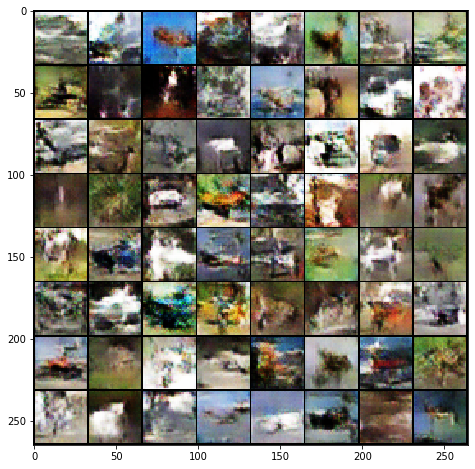

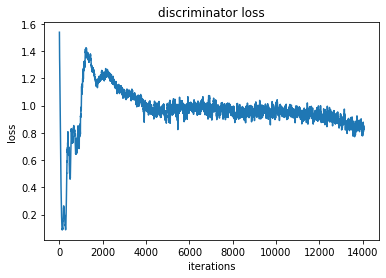

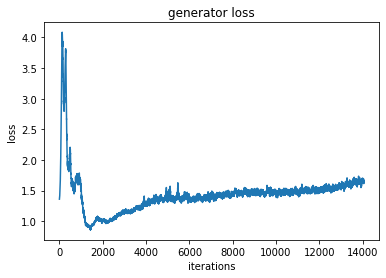

Iteration 14100/31240: dis loss = 1.1197, gen loss = 0.6776
Iteration 14150/31240: dis loss = 0.7764, gen loss = 1.8349
Iteration 14200/31240: dis loss = 0.9569, gen loss = 1.4302
Iteration 14250/31240: dis loss = 0.7310, gen loss = 3.1024
Iteration 14300/31240: dis loss = 0.6153, gen loss = 1.4591
Iteration 14350/31240: dis loss = 0.5708, gen loss = 2.1496
Iteration 14400/31240: dis loss = 0.8109, gen loss = 1.0891
Iteration 14450/31240: dis loss = 1.1124, gen loss = 2.4181
Iteration 14500/31240: dis loss = 0.7162, gen loss = 1.3596
Iteration 14550/31240: dis loss = 0.6365, gen loss = 1.9414
Iteration 14600/31240: dis loss = 0.7636, gen loss = 1.2265
Iteration 14650/31240: dis loss = 0.7605, gen loss = 2.0049
Iteration 14700/31240: dis loss = 1.1908, gen loss = 2.5426
Iteration 14750/31240: dis loss = 0.8165, gen loss = 0.9046
Iteration 14800/31240: dis loss = 0.8861, gen loss = 0.9828
Iteration 14850/31240: dis loss = 0.7365, gen loss = 2.6639
Iteration 14900/31240: dis loss = 0.9532

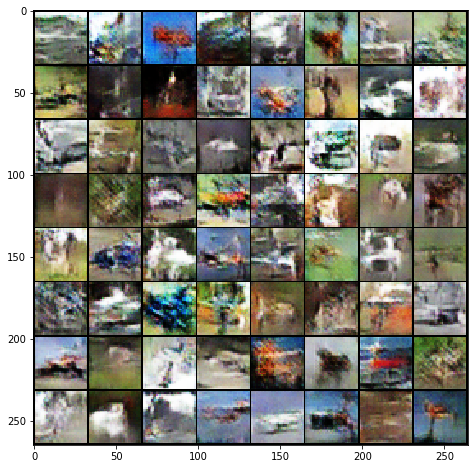

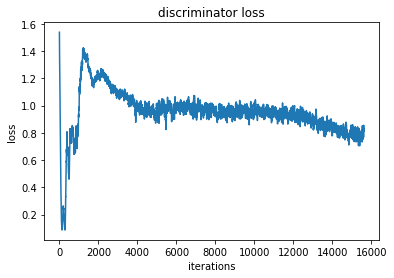

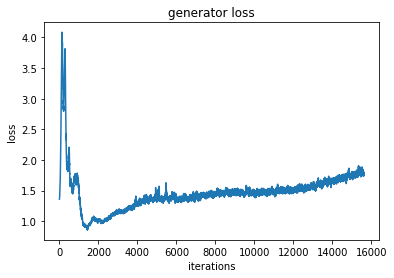

Iteration 15650/31240: dis loss = 0.8558, gen loss = 2.3014
Iteration 15700/31240: dis loss = 0.7553, gen loss = 2.6954
Iteration 15750/31240: dis loss = 0.8186, gen loss = 2.5347
Iteration 15800/31240: dis loss = 0.8230, gen loss = 2.5702
Iteration 15850/31240: dis loss = 0.6890, gen loss = 1.4286
Iteration 15900/31240: dis loss = 0.8461, gen loss = 1.4124
Iteration 15950/31240: dis loss = 0.7401, gen loss = 1.9494
Iteration 16000/31240: dis loss = 1.0709, gen loss = 2.3901
Iteration 16050/31240: dis loss = 0.8474, gen loss = 0.8544
Iteration 16100/31240: dis loss = 0.9427, gen loss = 0.6872
Iteration 16150/31240: dis loss = 0.7984, gen loss = 2.3871
Iteration 16200/31240: dis loss = 0.8741, gen loss = 1.8067
Iteration 16250/31240: dis loss = 0.7569, gen loss = 1.9655
Iteration 16300/31240: dis loss = 0.7070, gen loss = 1.3526
Iteration 16350/31240: dis loss = 0.6139, gen loss = 1.2830
Iteration 16400/31240: dis loss = 0.5850, gen loss = 2.2899
Iteration 16450/31240: dis loss = 0.6240

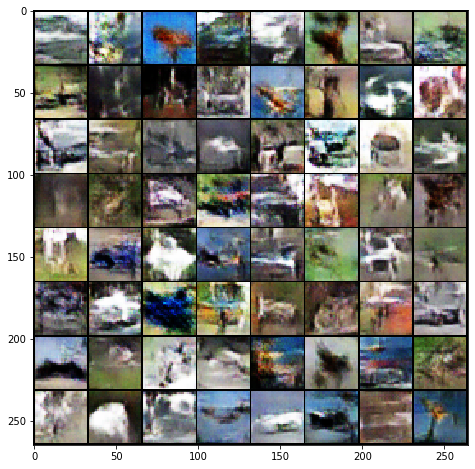

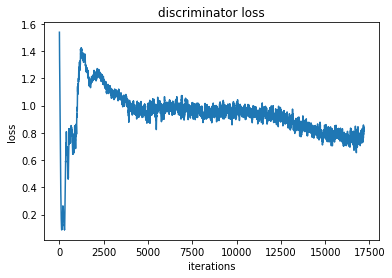

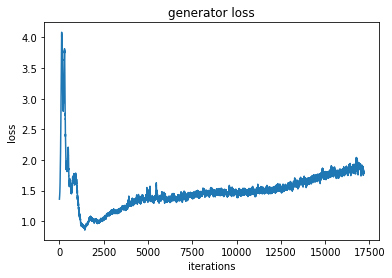

Iteration 17200/31240: dis loss = 0.6038, gen loss = 1.5092
Iteration 17250/31240: dis loss = 0.7344, gen loss = 1.0110
Iteration 17300/31240: dis loss = 0.7162, gen loss = 1.5813
Iteration 17350/31240: dis loss = 0.9188, gen loss = 0.8476
Iteration 17400/31240: dis loss = 0.8723, gen loss = 3.3654
Iteration 17450/31240: dis loss = 0.6314, gen loss = 1.4207
Iteration 17500/31240: dis loss = 0.6735, gen loss = 2.0954
Iteration 17550/31240: dis loss = 0.7382, gen loss = 2.8066
Iteration 17600/31240: dis loss = 0.7145, gen loss = 2.4479
Iteration 17650/31240: dis loss = 0.6798, gen loss = 1.9669
Iteration 17700/31240: dis loss = 1.0918, gen loss = 1.1847
Iteration 17750/31240: dis loss = 0.6660, gen loss = 2.3596
Iteration 17800/31240: dis loss = 0.7088, gen loss = 2.6213
Iteration 17850/31240: dis loss = 0.8679, gen loss = 2.7933
Iteration 17900/31240: dis loss = 1.3596, gen loss = 0.6645
Iteration 17950/31240: dis loss = 0.4148, gen loss = 2.2360
Iteration 18000/31240: dis loss = 1.1808

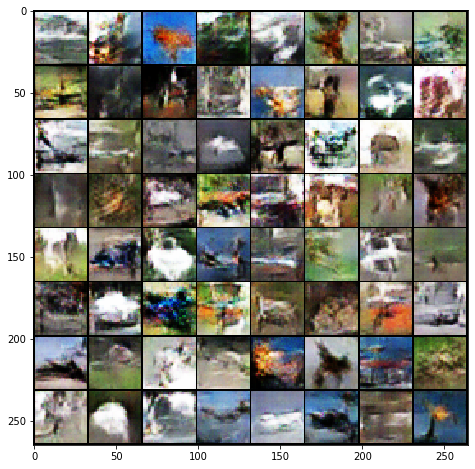

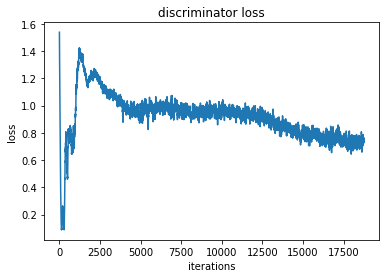

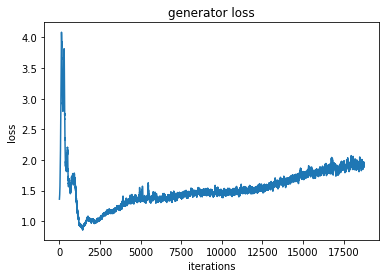

Iteration 18750/31240: dis loss = 0.7505, gen loss = 1.3168
Iteration 18800/31240: dis loss = 0.5935, gen loss = 2.1442
Iteration 18850/31240: dis loss = 0.6489, gen loss = 1.6921
Iteration 18900/31240: dis loss = 0.8782, gen loss = 0.6893
Iteration 18950/31240: dis loss = 0.8296, gen loss = 0.7586
Iteration 19000/31240: dis loss = 0.6631, gen loss = 1.3406
Iteration 19050/31240: dis loss = 0.9200, gen loss = 3.0783
Iteration 19100/31240: dis loss = 0.8989, gen loss = 1.7709
Iteration 19150/31240: dis loss = 0.8066, gen loss = 2.8810
Iteration 19200/31240: dis loss = 0.9397, gen loss = 2.4233
Iteration 19250/31240: dis loss = 0.7090, gen loss = 1.3261
Iteration 19300/31240: dis loss = 0.5726, gen loss = 2.0017
Iteration 19350/31240: dis loss = 0.7341, gen loss = 2.4833
Iteration 19400/31240: dis loss = 0.8521, gen loss = 1.9789
Iteration 19450/31240: dis loss = 0.6696, gen loss = 2.8485
Iteration 19500/31240: dis loss = 0.8854, gen loss = 0.7225
Iteration 19550/31240: dis loss = 0.7303

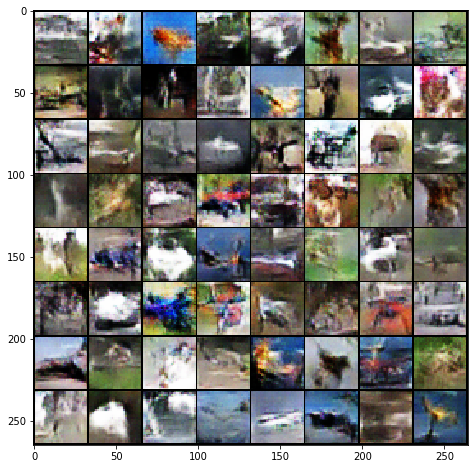

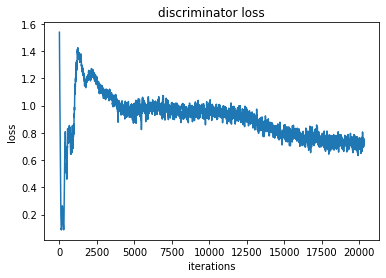

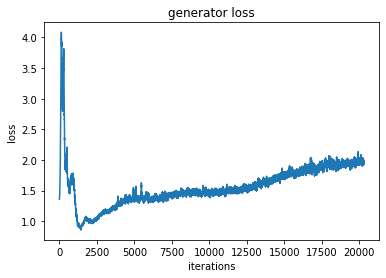

Iteration 20350/31240: dis loss = 0.6087, gen loss = 2.7601
Iteration 20400/31240: dis loss = 0.7252, gen loss = 1.3805
Iteration 20450/31240: dis loss = 0.6391, gen loss = 1.5612
Iteration 20500/31240: dis loss = 0.5797, gen loss = 2.5239
Iteration 20550/31240: dis loss = 0.7342, gen loss = 1.7274
Iteration 20600/31240: dis loss = 0.3960, gen loss = 2.1203
Iteration 20650/31240: dis loss = 0.4568, gen loss = 2.2567
Iteration 20700/31240: dis loss = 0.7548, gen loss = 1.1908
Iteration 20750/31240: dis loss = 0.4958, gen loss = 2.1090
Iteration 20800/31240: dis loss = 0.6001, gen loss = 1.7670
Iteration 20850/31240: dis loss = 0.4082, gen loss = 2.4276
Iteration 20900/31240: dis loss = 0.8511, gen loss = 2.0406
Iteration 20950/31240: dis loss = 0.6251, gen loss = 2.7618
Iteration 21000/31240: dis loss = 0.6608, gen loss = 1.2155
Iteration 21050/31240: dis loss = 0.5006, gen loss = 1.6084
Iteration 21100/31240: dis loss = 0.8183, gen loss = 2.5977
Iteration 21150/31240: dis loss = 0.5147

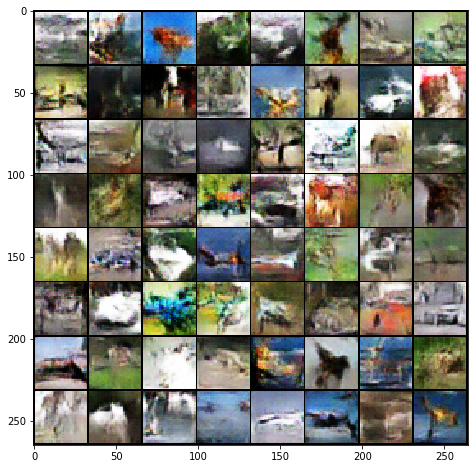

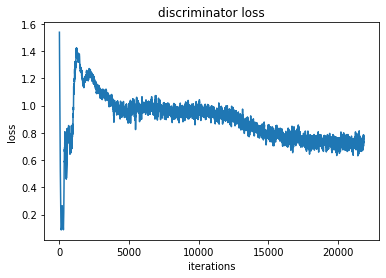

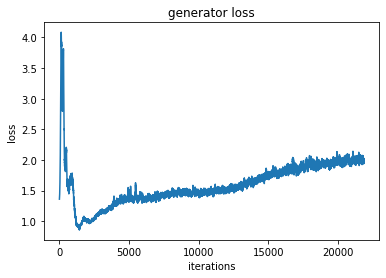

Iteration 21900/31240: dis loss = 0.4851, gen loss = 1.8198
Iteration 21950/31240: dis loss = 0.6080, gen loss = 2.2939
Iteration 22000/31240: dis loss = 1.0565, gen loss = 3.1561
Iteration 22050/31240: dis loss = 0.7492, gen loss = 2.1571
Iteration 22100/31240: dis loss = 1.3224, gen loss = 0.7498
Iteration 22150/31240: dis loss = 0.7756, gen loss = 3.1457
Iteration 22200/31240: dis loss = 0.8125, gen loss = 1.3490
Iteration 22250/31240: dis loss = 0.5098, gen loss = 2.4579
Iteration 22300/31240: dis loss = 0.7979, gen loss = 2.1768
Iteration 22350/31240: dis loss = 0.8673, gen loss = 2.2352
Iteration 22400/31240: dis loss = 0.7059, gen loss = 2.4664
Iteration 22450/31240: dis loss = 0.7718, gen loss = 1.1090
Iteration 22500/31240: dis loss = 1.1948, gen loss = 0.9159
Iteration 22550/31240: dis loss = 0.5394, gen loss = 2.4021
Iteration 22600/31240: dis loss = 0.6052, gen loss = 1.8350
Iteration 22650/31240: dis loss = 0.9030, gen loss = 2.7830
Iteration 22700/31240: dis loss = 0.4682

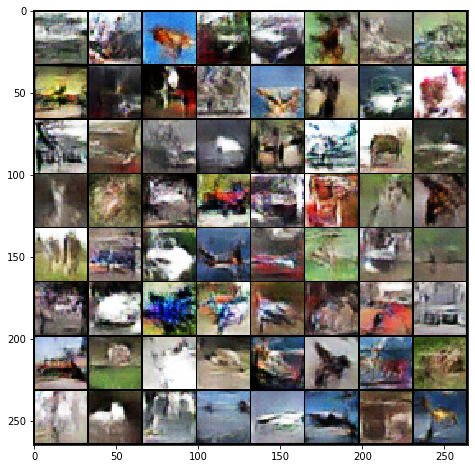

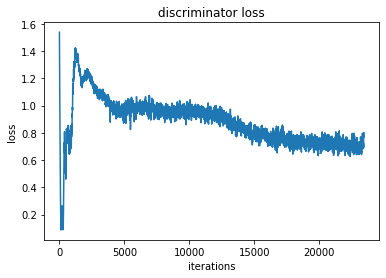

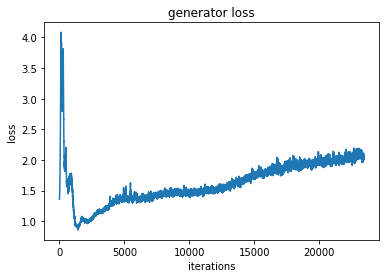

Iteration 23450/31240: dis loss = 0.6742, gen loss = 1.5393
Iteration 23500/31240: dis loss = 0.5340, gen loss = 1.8196
Iteration 23550/31240: dis loss = 0.4587, gen loss = 3.0996
Iteration 23600/31240: dis loss = 0.4461, gen loss = 2.1666
Iteration 23650/31240: dis loss = 0.3973, gen loss = 2.2152
Iteration 23700/31240: dis loss = 0.7008, gen loss = 1.6152
Iteration 23750/31240: dis loss = 0.4203, gen loss = 2.4037
Iteration 23800/31240: dis loss = 0.7027, gen loss = 2.6417
Iteration 23850/31240: dis loss = 0.5409, gen loss = 1.6888
Iteration 23900/31240: dis loss = 0.3884, gen loss = 2.2808
Iteration 23950/31240: dis loss = 0.8651, gen loss = 1.5278
Iteration 24000/31240: dis loss = 0.4016, gen loss = 1.5011
Iteration 24050/31240: dis loss = 0.6861, gen loss = 0.9265
Iteration 24100/31240: dis loss = 0.5187, gen loss = 2.6315
Iteration 24150/31240: dis loss = 0.7028, gen loss = 1.3233
Iteration 24200/31240: dis loss = 0.5871, gen loss = 1.5890
Iteration 24250/31240: dis loss = 0.4746

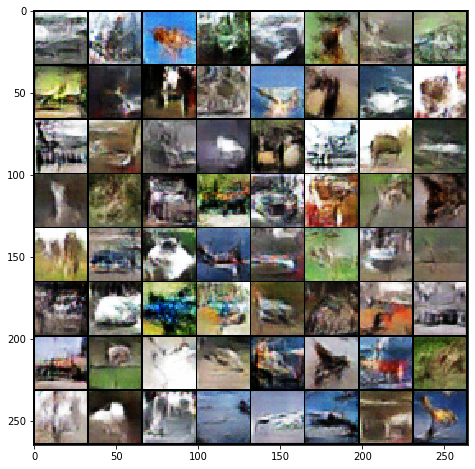

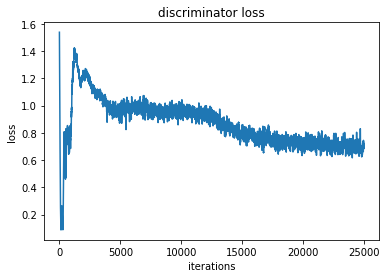

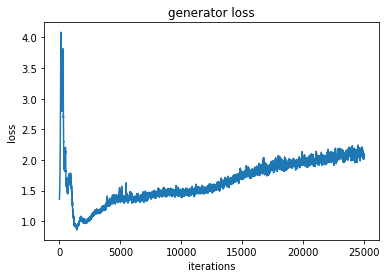

Iteration 25000/31240: dis loss = 0.6344, gen loss = 2.0836
Iteration 25050/31240: dis loss = 0.5261, gen loss = 2.6646
Iteration 25100/31240: dis loss = 0.8318, gen loss = 1.0963
Iteration 25150/31240: dis loss = 0.5974, gen loss = 1.6349
Iteration 25200/31240: dis loss = 1.2978, gen loss = 3.8046
Iteration 25250/31240: dis loss = 0.8294, gen loss = 1.0748
Iteration 25300/31240: dis loss = 0.8916, gen loss = 2.9339
Iteration 25350/31240: dis loss = 0.7381, gen loss = 2.3191
Iteration 25400/31240: dis loss = 0.5824, gen loss = 2.7433
Iteration 25450/31240: dis loss = 0.5375, gen loss = 2.0450
Iteration 25500/31240: dis loss = 0.4757, gen loss = 1.6801
Iteration 25550/31240: dis loss = 1.3567, gen loss = 3.4464
Iteration 25600/31240: dis loss = 0.3563, gen loss = 2.0638
Iteration 25650/31240: dis loss = 0.8908, gen loss = 1.3274
Iteration 25700/31240: dis loss = 0.7278, gen loss = 2.7896
Iteration 25750/31240: dis loss = 0.7021, gen loss = 1.2637
Iteration 25800/31240: dis loss = 0.4773

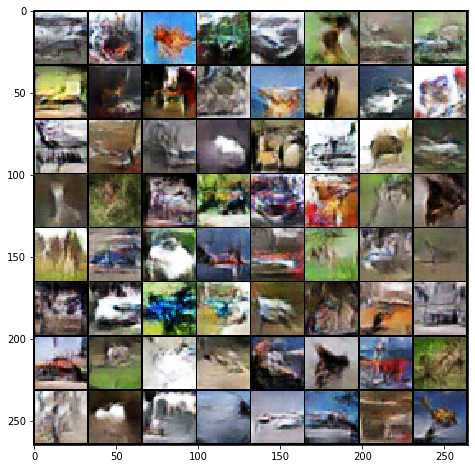

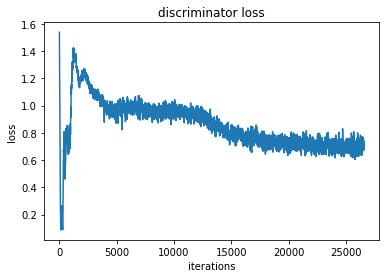

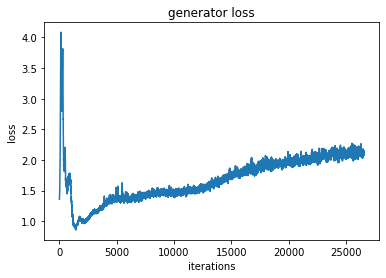

Iteration 26600/31240: dis loss = 0.8156, gen loss = 1.3624
Iteration 26650/31240: dis loss = 0.5314, gen loss = 1.4892
Iteration 26700/31240: dis loss = 0.7162, gen loss = 1.6511
Iteration 26750/31240: dis loss = 0.8390, gen loss = 2.5300
Iteration 26800/31240: dis loss = 0.4930, gen loss = 2.7528
Iteration 26850/31240: dis loss = 0.6137, gen loss = 1.8145
Iteration 26900/31240: dis loss = 0.4589, gen loss = 2.3719
Iteration 26950/31240: dis loss = 0.4452, gen loss = 2.6190
Iteration 27000/31240: dis loss = 0.4546, gen loss = 2.1966
Iteration 27050/31240: dis loss = 0.5759, gen loss = 1.8586
Iteration 27100/31240: dis loss = 0.6251, gen loss = 3.4740
Iteration 27150/31240: dis loss = 0.5761, gen loss = 2.6097
Iteration 27200/31240: dis loss = 0.8144, gen loss = 1.8243
Iteration 27250/31240: dis loss = 0.5258, gen loss = 2.3389
Iteration 27300/31240: dis loss = 0.8949, gen loss = 3.6586
Iteration 27350/31240: dis loss = 0.7046, gen loss = 1.7849
Iteration 27400/31240: dis loss = 0.7907

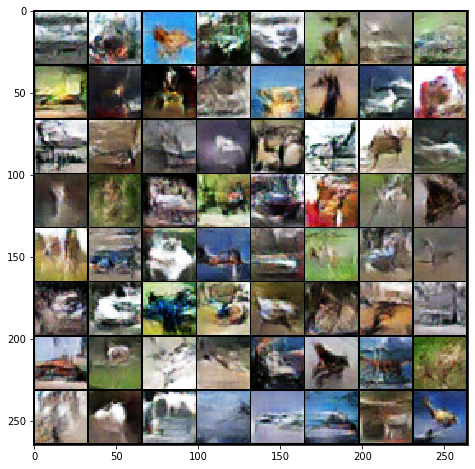

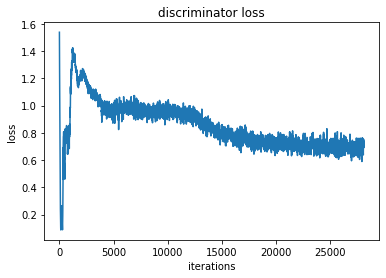

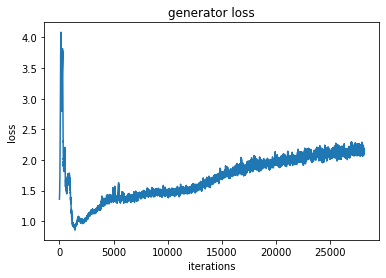

Iteration 28150/31240: dis loss = 0.4649, gen loss = 3.2206
Iteration 28200/31240: dis loss = 0.9556, gen loss = 3.4264
Iteration 28250/31240: dis loss = 0.7405, gen loss = 1.4028
Iteration 28300/31240: dis loss = 0.7813, gen loss = 2.6230
Iteration 28350/31240: dis loss = 0.8566, gen loss = 1.0532
Iteration 28400/31240: dis loss = 0.4210, gen loss = 2.9586
Iteration 28450/31240: dis loss = 0.8389, gen loss = 1.0569
Iteration 28500/31240: dis loss = 0.2370, gen loss = 2.7707
Iteration 28550/31240: dis loss = 0.4203, gen loss = 2.0793
Iteration 28600/31240: dis loss = 0.5928, gen loss = 2.2451
Iteration 28650/31240: dis loss = 0.7365, gen loss = 2.6035
Iteration 28700/31240: dis loss = 0.7565, gen loss = 1.3922
Iteration 28750/31240: dis loss = 0.9221, gen loss = 2.3464
Iteration 28800/31240: dis loss = 0.8502, gen loss = 3.0541
Iteration 28850/31240: dis loss = 0.5677, gen loss = 1.3968
Iteration 28900/31240: dis loss = 0.3736, gen loss = 2.2866
Iteration 28950/31240: dis loss = 0.5684

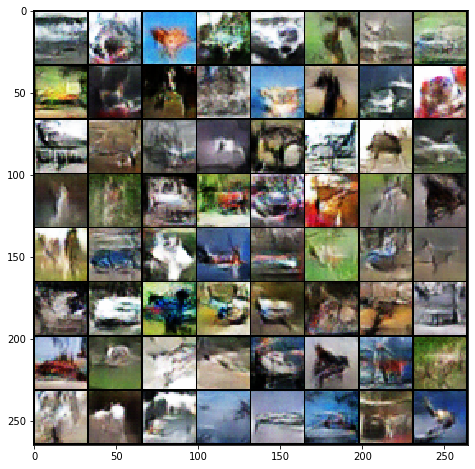

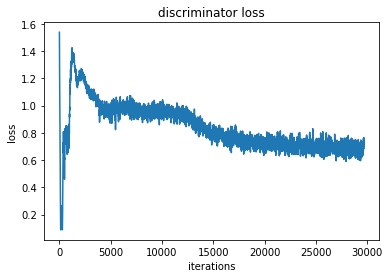

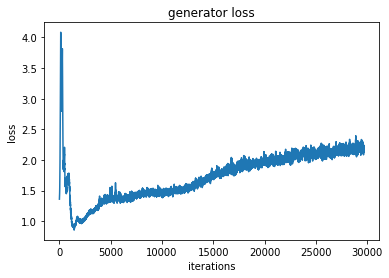

Iteration 29700/31240: dis loss = 1.2609, gen loss = 0.8068
Iteration 29750/31240: dis loss = 0.4762, gen loss = 3.2474
Iteration 29800/31240: dis loss = 0.5313, gen loss = 1.7874
Iteration 29850/31240: dis loss = 0.6931, gen loss = 2.0485
Iteration 29900/31240: dis loss = 0.5181, gen loss = 2.0731
Iteration 29950/31240: dis loss = 0.5648, gen loss = 1.4286
Iteration 30000/31240: dis loss = 0.9190, gen loss = 2.1653
Iteration 30050/31240: dis loss = 0.4265, gen loss = 3.0297
Iteration 30100/31240: dis loss = 0.3536, gen loss = 3.4223
Iteration 30150/31240: dis loss = 0.4645, gen loss = 2.0318
Iteration 30200/31240: dis loss = 0.3683, gen loss = 2.6566
Iteration 30250/31240: dis loss = 0.4063, gen loss = 2.8810
Iteration 30300/31240: dis loss = 0.9797, gen loss = 1.9450
Iteration 30350/31240: dis loss = 0.5750, gen loss = 2.6357
Iteration 30400/31240: dis loss = 0.5691, gen loss = 2.0400
Iteration 30450/31240: dis loss = 0.4721, gen loss = 2.1809
Iteration 30500/31240: dis loss = 0.6270

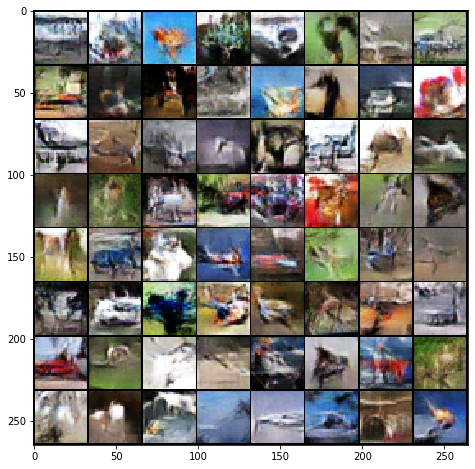

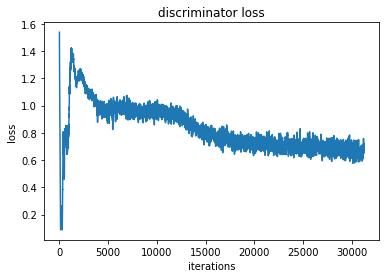

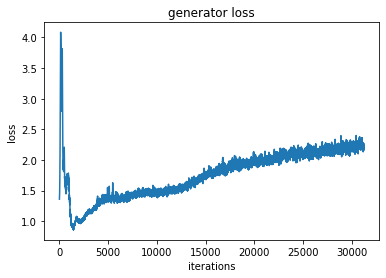

... Done!


In [5]:
tf.reset_default_graph()
set_seed(21)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/dcgan


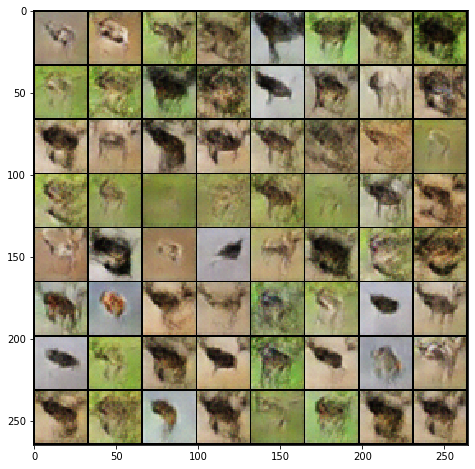

In [6]:
tf.reset_default_graph()
set_seed(241)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

INFO:tensorflow:Restoring parameters from model/dcgan
average reconstruction loss = 29.5316


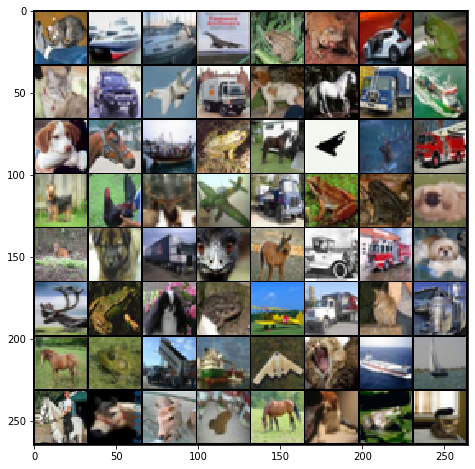

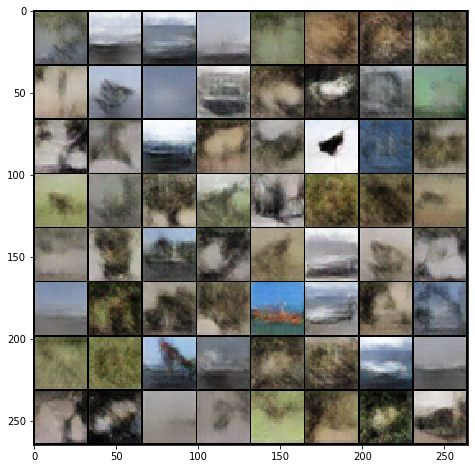

In [7]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(test_samples[0:64], 1))
        plt.show()
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(reconstructions, 1))
        plt.show()